In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/labeled_training (2).csv')
df_dev = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H_2024_Task6_Dev.csv')
df_test = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/unlabeled_testing.csv')

In [3]:
print(len(df_train))
print(len(df_dev))
print(len(df_test))

8800
4200
8200


In [4]:
import re
import pandas as pd
def preprocess_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.lower()
    text = re.sub(r'[@#]\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df_train['text'] = df_train['text'].apply(preprocess_text)
df_dev['text'] = df_dev['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [5]:
!pip install transformers seqeval torch tqdm accelerate sentencepiece datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 43.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvid

In [6]:
df_merged = pd.concat([df_train, df_dev]).sort_index(kind='merge').reset_index(drop=True)
df_merged

,id,text,source,label
0,1,at 50 votes i will close this survey and take ...,twitter,0
1,8801,everybody developa cataracts with age. disease...,reddit,0
2,2,"21st birthday and nearly 4 months pregnant, no...",twitter,1
3,8802,"i have not heard that before. i have icl's, bu...",reddit,0
4,3,// i'd be killed. he's literally my 10th picture.,twitter,0
...,...,...,...,...
12995,8796,happy birthday brandon james. hope you have a ...,twitter,0
12996,8797,"at age 50, i remember cheering ""bananas"" befor...",twitter,0
12997,8798,them springfield mall pictures.. lol.,twitter,1
12998,8799,when we turn 18 were going idgaf where its at....,twitter,0


In [7]:
print(df_merged['source'].value_counts())
print(df_train['source'].value_counts())
print(df_dev['source'].value_counts())
print(df_train['source'].value_counts())

source
twitter    11000
reddit      2000
Name: count, dtype: int64
source
twitter    8800
Name: count, dtype: int64
source
twitter    2200
reddit     2000
Name: count, dtype: int64
source
twitter    8800
Name: count, dtype: int64


In [8]:
df_train_1 = df_train
df_dev_1 = df_dev[df_dev['source'] == 'twitter']
reddit_data = df_dev[df_dev['source'] == 'reddit']
df_train_2 = reddit_data.sample(frac=0.9, random_state=69)  # Use random_state for reproducibility
df_dev_2 = reddit_data.drop(df_train_2.index)

In [9]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy, TrainerCallback
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
import os
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
class SaveModelCallback(TrainerCallback):
    def __init__(self, output_dir):
        self.output_dir = output_dir
    def on_epoch_end(self, args, state, control, **kwargs):
        output_dir = os.path.join(self.output_dir, f"epoch_bartlarge_B_{state.epoch}")
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
texts = df_train_2['text'].tolist()
labels = df_train_2['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=2) # Adjust num_labels as per your requirement
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results_temp',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy=IntervalStrategy.NO,
    save_strategy=IntervalStrategy.NO,
    load_best_model_at_end=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    callbacks=[SaveModelCallback(output_dir='./model_saves')]
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
100,0.490300
200,0.288200
300,0.156900
400,0.202700
500,0.123300
600,0.112100
700,0.080600
800,0.050800
900,0.074400
1000,0.049800


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=2250, training_loss=0.08037139065470547, metrics={'train_runtime': 2034.8127, 'train_samples_per_second': 8.846, 'train_steps_per_second': 1.106, 'total_flos': 1.9562093457408e+16, 'train_loss': 0.08037139065470547, 'epoch': 10.0})

In [10]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])

In [16]:
df_merged_1

,id,text,source,label,predicted_label,prediction_0_weight,prediction_1_weight
0,8810,ok so i came back from the retina specialist t...,reddit,1,1,0.017799,0.982201
1,8820,i was in rgp's 1968-1982. these are so much mo...,reddit,0,0,0.998744,0.001256
2,8838,the total diopters of the eye is about 60. 20 ...,reddit,0,0,0.998833,0.001168
3,8854,lots of your previous posts were helpful so it...,reddit,0,0,0.998066,0.001935
4,8866,i was 25 when i had the surgery done in my rig...,reddit,1,0,0.996754,0.003246
...,...,...,...,...,...,...,...
195,12972,want to start dating - but im really socially ...,reddit,1,1,0.000768,0.999232
196,12984,"i was always shy as a kid, got bullied and was...",reddit,1,1,0.001780,0.998219
197,12985,i'm 25 and play video games for a little while...,reddit,1,1,0.000993,0.999007
198,12989,i am 13 and i want to get over it but it's eas...,reddit,1,1,0.001853,0.998147


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

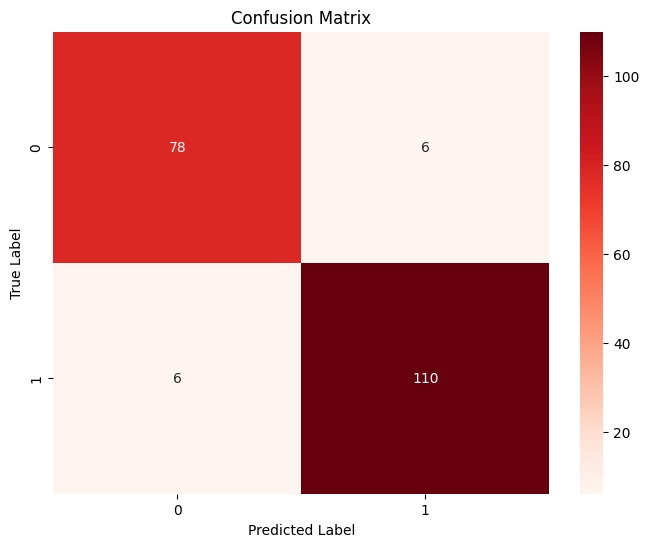

Accuracy: 0.94
F1 Score (Class 1): 0.9482758620689655
Recall (Macro): 0.9384236453201971
Precision (Macro): 0.9384236453201971


In [15]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_1.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_1.reset_index(drop=True, inplace=True)
df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_1['label']                                                                                                   #THIS
predicted_labels = df_merged_1['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('BartLargeB_task6_predictions_002_epoch_1.csv', index=False)                     #XXX                           #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

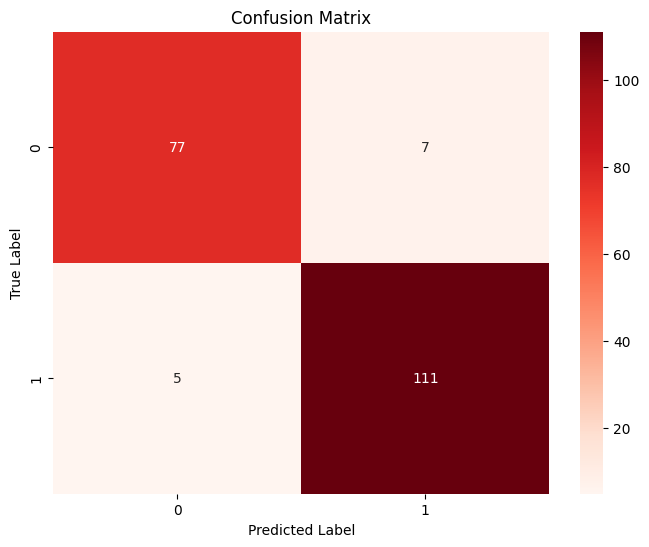

Accuracy: 0.94
F1 Score (Class 1): 0.9487179487179486
Recall (Macro): 0.9367816091954022
Precision (Macro): 0.9398511781727987


In [17]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_2.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_2 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_2.reset_index(drop=True, inplace=True)            #THIS
df_merged_2 = pd.concat([df_dev_2, df_predictions_2], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_2['label']                                                                                                   #THIS
predicted_labels = df_merged_2['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_2.to_csv('BartLargeB_task6_predictions_002_epoch_2.csv', index=False)                     #XXX                           #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

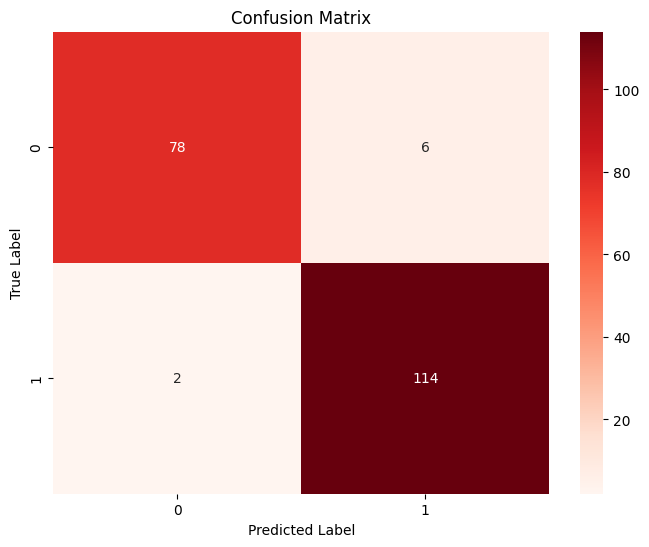

Accuracy: 0.96
F1 Score (Class 1): 0.9661016949152542
Recall (Macro): 0.9556650246305418
Precision (Macro): 0.9624999999999999


In [18]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_3.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_3 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_3.reset_index(drop=True, inplace=True)            #THIS
df_merged_3 = pd.concat([df_dev_2, df_predictions_3], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_3['label']                                                                                                   #THIS
predicted_labels = df_merged_3['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_3.to_csv('BartLargeB_task6_predictions_002_epoch_3.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

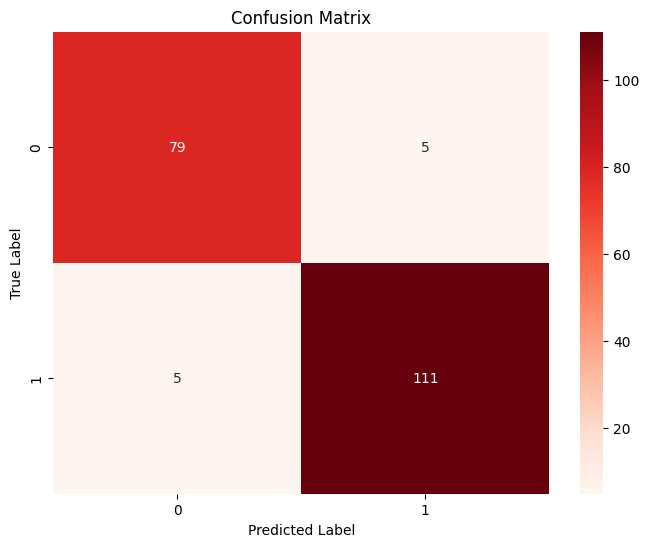

Accuracy: 0.95
F1 Score (Class 1): 0.9568965517241379
Recall (Macro): 0.9486863711001642
Precision (Macro): 0.9486863711001642


In [19]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_4.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_4 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_4.reset_index(drop=True, inplace=True)            #THIS
df_merged_4 = pd.concat([df_dev_2, df_predictions_4], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_4['label']                                                                                                   #THIS
predicted_labels = df_merged_4['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_4.to_csv('BartLargeB_task6_predictions_002_epoch_4.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

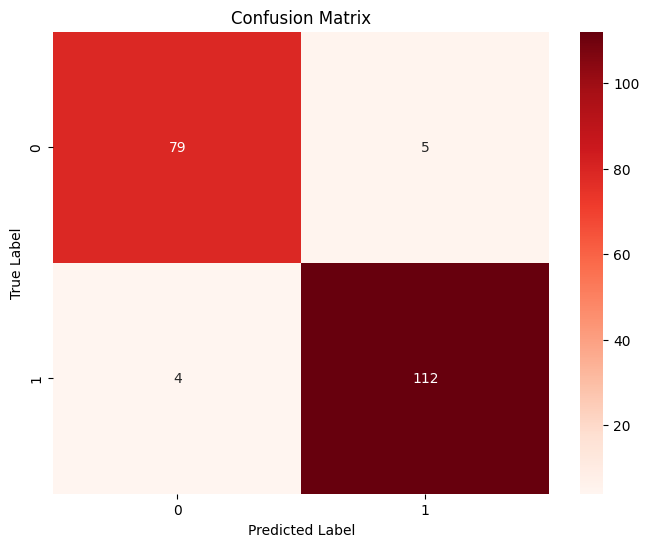

Accuracy: 0.955
F1 Score (Class 1): 0.9613733905579399
Recall (Macro): 0.9529967159277504
Precision (Macro): 0.95453609309031


In [20]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_5.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_5 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_5.reset_index(drop=True, inplace=True)            #THIS
df_merged_5 = pd.concat([df_dev_2, df_predictions_5], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_5['label']                                                                                                   #THIS
predicted_labels = df_merged_5['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_5.to_csv('BartLargeB_task6_predictions_002_epoch_5.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

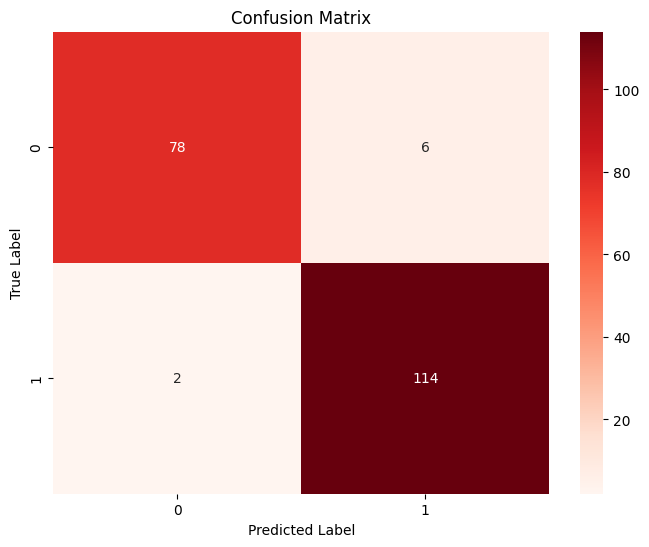

Accuracy: 0.96
F1 Score (Class 1): 0.9661016949152542
Recall (Macro): 0.9556650246305418
Precision (Macro): 0.9624999999999999


In [21]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_6.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_6 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_6.reset_index(drop=True, inplace=True)            #THIS
df_merged_6 = pd.concat([df_dev_2, df_predictions_6], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_6['label']                                                                                                   #THIS
predicted_labels = df_merged_6['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_6.to_csv('BartLargeB_task6_predictions_002_epoch_6.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

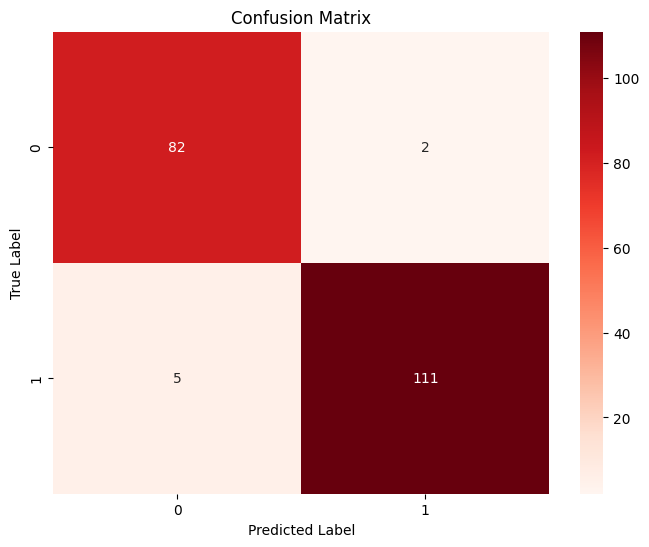

Accuracy: 0.965
F1 Score (Class 1): 0.9694323144104803
Recall (Macro): 0.9665435139573071
Precision (Macro): 0.962414810293968


In [22]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_7.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_7 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_7.reset_index(drop=True, inplace=True)            #THIS
df_merged_7 = pd.concat([df_dev_2, df_predictions_7], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_7['label']                                                                                                   #THIS
predicted_labels = df_merged_7['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_7.to_csv('BartLargeB_task6_predictions_002_epoch_7.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

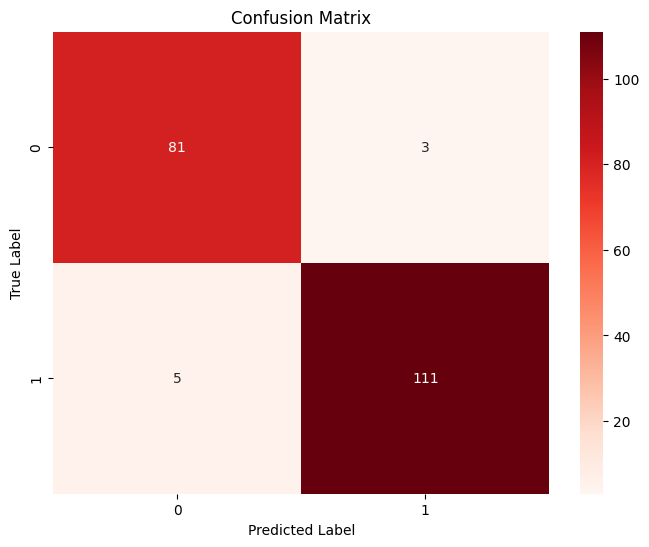

Accuracy: 0.96
F1 Score (Class 1): 0.9652173913043478
Recall (Macro): 0.9605911330049262
Precision (Macro): 0.9577723378212974


In [23]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_8.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_8 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_8.reset_index(drop=True, inplace=True)            #THIS
df_merged_8 = pd.concat([df_dev_2, df_predictions_8], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_8['label']                                                                                                   #THIS
predicted_labels = df_merged_8['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_8.to_csv('BartLargeB_task6_predictions_002_epoch_8.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

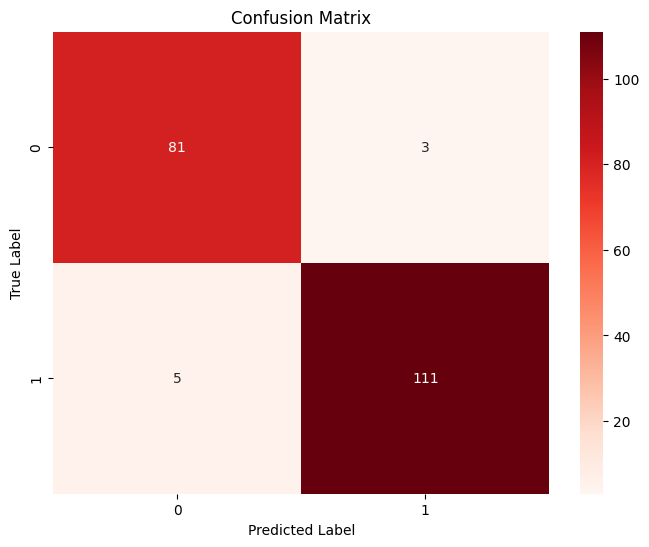

Accuracy: 0.96
F1 Score (Class 1): 0.9652173913043478
Recall (Macro): 0.9605911330049262
Precision (Macro): 0.9577723378212974


In [24]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_9.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_9 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_9.reset_index(drop=True, inplace=True)            #THIS
df_merged_9 = pd.concat([df_dev_2, df_predictions_9], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_9['label']                                                                                                   #THIS
predicted_labels = df_merged_9['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_9.to_csv('BartLargeB_task6_predictions_002_epoch_9.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

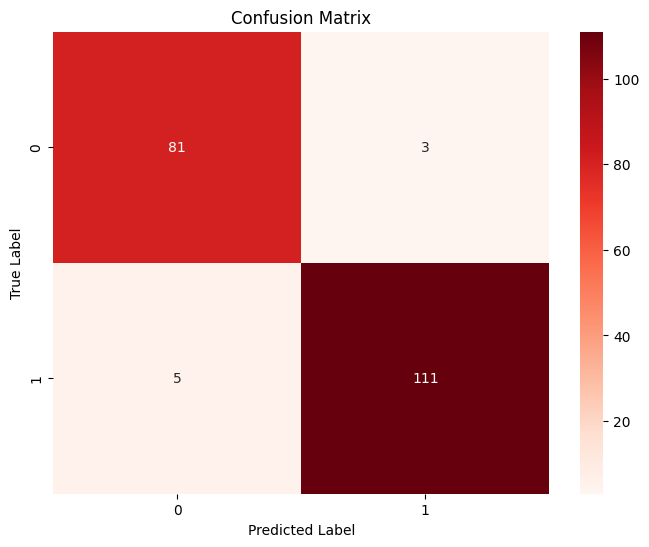

Accuracy: 0.96
F1 Score (Class 1): 0.9652173913043478
Recall (Macro): 0.9605911330049262
Precision (Macro): 0.9577723378212974


In [25]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_B_10.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev_2['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_10 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS

df_dev_2.reset_index(drop=True, inplace=True)
df_predictions_10.reset_index(drop=True, inplace=True)            #THIS
df_merged_10 = pd.concat([df_dev_2, df_predictions_10], axis=1)    # THIS # THIS

#df_merged_1 = pd.concat([df_dev_2, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_10['label']                                                                                                   #THIS
predicted_labels = df_merged_10['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_10.to_csv('BartLargeB_task6_predictions_002_epoch_10.csv', index=False)                     #XXX                          #THIS #THIS

In [26]:
!pip install transformers huggingface_hub

In [27]:
from huggingface_hub import notebook_login
notebook_login()

In [33]:
from huggingface_hub import HfApi, create_repo, upload_folder
hf_username = "1024m"  # Replace with your actual username
repo_name = "SMM4H-Task6-BartL-B10"  # Name of the new repository
api = HfApi()
if not api.repo_exists(f"{hf_username}/{repo_name}"):
    create_repo(repo_name,private=False)
model_directory = '/content/model_saves/epoch_bartlarge_B_10.0'
upload_folder(
    folder_path=model_directory,
    repo_id=f"{hf_username}/{repo_name}"
)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/1024m/SMM4H-Task6-BartL-B10/commit/db957ce0d71a234792ee15f8b3313403b91a1dd9', commit_message='Upload folder using huggingface_hub', commit_description='', oid='db957ce0d71a234792ee15f8b3313403b91a1dd9', pr_url=None, pr_revision=None, pr_num=None)